# 🏡 California Housing Price Prediction

This notebook demonstrates the complete workflow for predicting housing prices using the California Housing dataset.

We will cover the following steps:
1. Import Libraries  
2. Load Dataset  
3. Exploratory Data Analysis (EDA)  
4. Data Preprocessing  
5. Train-Test Split  
6. Feature Scaling & Encoding  
7. Model Training (Linear & Ridge Regression)  
8. Model Evaluation  
9. Feature Importance Analysis  
10. Residual Analysis  

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score

## Step 2: Load Dataset

In [2]:
data = pd.read_csv("./data/housing.csv")
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Step 3: Exploratory Data Analysis (EDA)

In [3]:
print(data.shape)
data.info()
data.describe()
print(data.isnull().sum())

(20640, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean

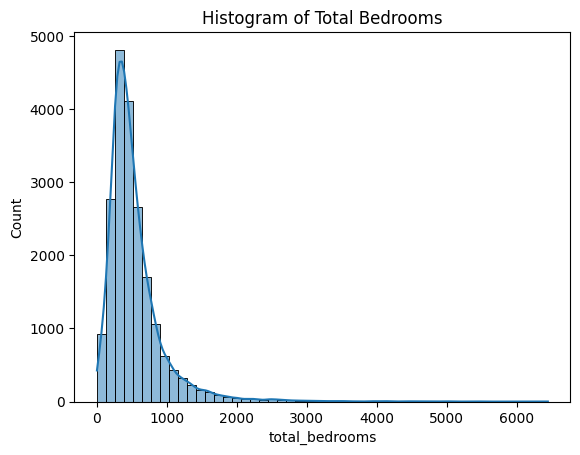

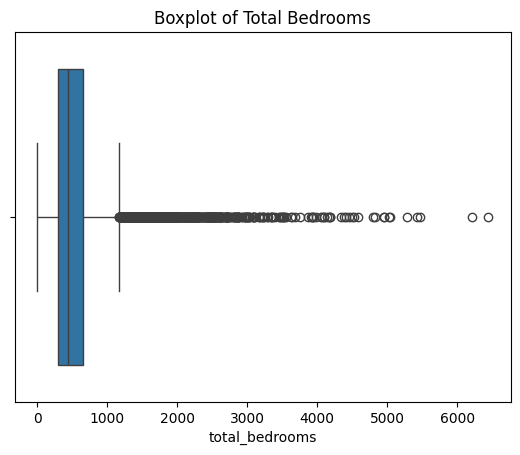

In [4]:
# Histogram of total_bedrooms
sns.histplot(data["total_bedrooms"], bins=50, kde=True)
plt.title("Histogram of Total Bedrooms")
plt.show()

# Boxplot of total_bedrooms
sns.boxplot(x=data["total_bedrooms"])
plt.title("Boxplot of Total Bedrooms")
plt.show()

## Step 4: Data Preprocessing

In [5]:
imputer = SimpleImputer(strategy="median")
data[["total_bedrooms"]] = imputer.fit_transform(data[["total_bedrooms"]])

# Log transform
data["total_bedrooms_log"] = np.log1p(data["total_bedrooms"])

# Ratio features
data["rooms_per_household"] = data["total_rooms"] / data["households"]
data["bedrooms_per_room"] = data["total_bedrooms"] / data["total_rooms"]
data["population_per_household"] = data["population"] / data["households"]

# Drop redundant columns
data = data.drop(columns=["total_bedrooms", "total_rooms", "population", "households"])

# One-hot encoding
data = pd.get_dummies(data, columns=["ocean_proximity"], drop_first=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   longitude                   20640 non-null  float64
 1   latitude                    20640 non-null  float64
 2   housing_median_age          20640 non-null  float64
 3   median_income               20640 non-null  float64
 4   median_house_value          20640 non-null  float64
 5   total_bedrooms_log          20640 non-null  float64
 6   rooms_per_household         20640 non-null  float64
 7   bedrooms_per_room           20640 non-null  float64
 8   population_per_household    20640 non-null  float64
 9   ocean_proximity_INLAND      20640 non-null  bool   
 10  ocean_proximity_ISLAND      20640 non-null  bool   
 11  ocean_proximity_NEAR BAY    20640 non-null  bool   
 12  ocean_proximity_NEAR OCEAN  20640 non-null  bool   
dtypes: bool(4), float64(9)
memory u

## Step 5: Train-Test Split

In [6]:
X = data.drop(columns=["median_house_value"])
y = data["median_house_value"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Step 6: Feature Scaling & Encoding

In [7]:
# Convert booleans to int
bool_cols = X_train.select_dtypes(include=["bool"]).columns
X_train[bool_cols] = X_train[bool_cols].astype(int)
X_test[bool_cols] = X_test[bool_cols].astype(int)

# Scale numerical columns
num_cols = X_train.select_dtypes(include=["float64"]).columns
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

## Step 7: Model Training

In [8]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Ridge Regression
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)

## Step 8: Model Evaluation

In [9]:
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    accuracy = 100 - mape
    return rmse, r2, accuracy

# Evaluate both models
rmse_lr, r2_lr, acc_lr = evaluate_model(y_test, y_pred_lr)
rmse_ridge, r2_ridge, acc_ridge = evaluate_model(y_test, y_pred_ridge)

print(f"Linear Regression -> RMSE: {rmse_lr:.2f}, R²: {r2_lr:.3f}, Accuracy: {acc_lr:.2f}%")
print(f"Ridge Regression  -> RMSE: {rmse_ridge:.2f}, R²: {r2_ridge:.3f}, Accuracy: {acc_ridge:.2f}%")

Linear Regression -> RMSE: 76014.65, R²: 0.559, Accuracy: 69.02%
Ridge Regression  -> RMSE: 76023.53, R²: 0.559, Accuracy: 69.02%


## Step 9: Feature Importance

In [10]:
coefficients = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": lr_model.coef_
}).sort_values(by="Coefficient", key=abs, ascending=False)

coefficients

,Feature,Coefficient
9,ocean_proximity_ISLAND,138839.317794
3,median_income,82361.967177
0,longitude,-52791.086994
1,latitude,-51206.825865
8,ocean_proximity_INLAND,-34107.752048
6,bedrooms_per_room,18957.336050
2,housing_median_age,14461.961441
4,total_bedrooms_log,9931.778591
11,ocean_proximity_NEAR OCEAN,8849.225528
5,rooms_per_household,8075.759557


## Step 10: Residual Analysis

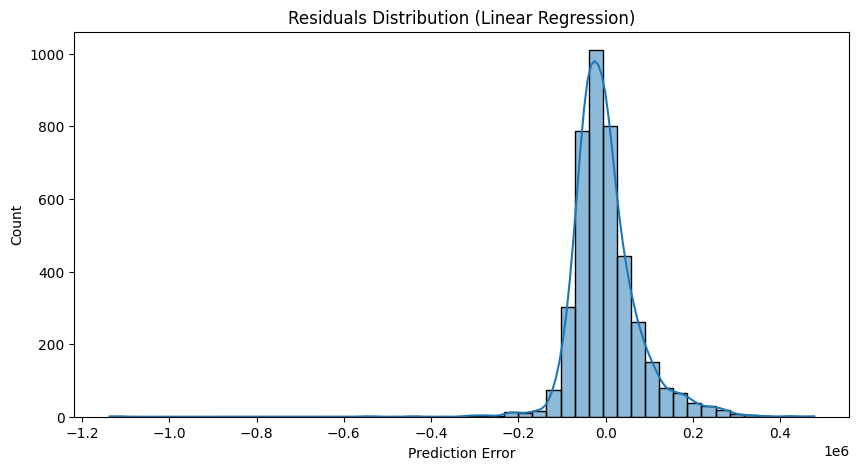

In [11]:
plt.figure(figsize=(10,5))
sns.histplot(y_test - y_pred_lr, bins=50, kde=True)
plt.title("Residuals Distribution (Linear Regression)")
plt.xlabel("Prediction Error")
plt.show()

# ✅ Conclusion

- Data was cleaned, transformed, and engineered into meaningful features.  
- Both Linear and Ridge Regression models were trained.  
- Ridge Regression slightly improves performance by reducing overfitting.  
- **Median Income** is the strongest predictor of housing prices.  
- The model explains ~55-60% of variance in housing prices (R²).  